In [1]:
import sys
sys.path.append(".")

# also disable grad to save memory
import torch
torch.set_grad_enabled(False)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import yaml
import torch
from omegaconf import OmegaConf
from taming.models.vqgan import VQModel, GumbelVQ

def load_config(config_path, display=False):
  config = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config)))
  return config

def load_vqgan(config, ckpt_path=None, is_gumbel=False):
  if is_gumbel:
    model = GumbelVQ(**config.model.params)
  else:
    model = VQModel(**config.model.params)
  if ckpt_path is not None:
    sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(sd, strict=False)
  return model.eval()

def preprocess_vqgan(x):
  x = 2.*x - 1.
  return x

def custom_to_pil(x):
  x = x.detach().cpu()
  x = torch.clamp(x, -1., 1.)
  x = (x + 1.)/2.
  x = x.permute(1,2,0).numpy()
  x = (255*x).astype(np.uint8)
  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

def reconstruct_with_vqgan(x, model):
  # could also use model(x) for reconstruction but use explicit encoding and decoding here
  z, _, [_, _, indices] = model.encode(x)
  print(f"indices is {indices}")
  print(f"z is {z.shape}")
  print(f"VQGAN --- {model.__class__.__name__}: latent shape: {z.shape[2:]}")
  xrec = model.decode(z)
  return xrec

/home/myid/ty45972/miniconda3/envs/VQGAN/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
config1024 = load_config("logs/vqgan_imagenet_f16_1024/configs/model.yaml", display=False)
config16384 = load_config("logs/vqgan_imagenet_f16_16384/configs/model.yaml", display=False)

model1024 = load_vqgan(config1024, ckpt_path="logs/vqgan_imagenet_f16_1024/checkpoints/last.ckpt").to(DEVICE)
model16384 = load_vqgan(config16384, ckpt_path="logs/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(DEVICE)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/home/myid/ty45972/miniconda3/envs/VQGAN/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/myid/ty45972/miniconda3/envs/VQGAN/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [4]:
# config32x32 = load_config("logs/vqgan_gumbel_f8/configs/model.yaml", display=False)
# model32x32 = load_vqgan(config32x32, ckpt_path="logs/vqgan_gumbel_f8/checkpoints/last.ckpt", is_gumbel=True).to(DEVICE)

In [5]:
import io
import os, sys
import requests
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from dall_e          import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown

# font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf", 22)
font = ImageFont.load_default()

def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))


def preprocess(img, target_image_size=256, map_dalle=True):
    print(f"image size is {img.size}")
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    if map_dalle: 
      img = map_pixels(img)
    return img


def reconstruct_with_dalle(x, encoder, decoder, do_preprocess=False):
  # takes in tensor (or optionally, a PIL image) and returns a PIL image
  if do_preprocess:
    x = preprocess(x)
  z_logits = encoder(x)
  z = torch.argmax(z_logits, axis=1)
  
  print(f"DALL-E: latent shape: {z.shape}")
  z = F.one_hot(z, num_classes=encoder.vocab_size).permute(0, 3, 1, 2).float()

  x_stats = decoder(z).float()
  x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
  x_rec = T.ToPILImage(mode='RGB')(x_rec[0])

  return x_rec


def stack_reconstructions(input, x1, x2, titles=[]):
    assert input.size == x1.size == x2.size
    w, h = input.size[0], input.size[1]
    print(f"width is {w}, height is {h}")
    img = Image.new("RGB", (3 * w, h))
    img.paste(input, (0, 0))
    img.paste(x1, (1 * w, 0))
    img.paste(x2, (2 * w, 0))
    for i, title in enumerate(titles):
        ImageDraw.Draw(img).text((i * w, 0), f'{title}', (255, 255, 255), font=ImageFont.load_default())  # 使用默认字体
    return img

In [6]:
# # For faster load times, download these files locally and use the local paths instead.
# encoder_dalle = load_model("https://cdn.openai.com/dall-e/encoder.pkl", DEVICE)
# decoder_dalle = load_model("https://cdn.openai.com/dall-e/decoder.pkl", DEVICE)

In [7]:
# titles=["Input", "DALL-E dVAE (f8, 8192)", "VQGAN (f8, 8192)", 
#         "VQGAN (f16, 16384)", "VQGAN (f16, 1024)"]

titles=["Input", "VQGAN (f16, 16384)", "VQGAN (f16, 1024)"]

def reconstruction_pipeline(url, size=320):
  x_dalle = preprocess(download_image(url), target_image_size=size, map_dalle=True)
  x_vqgan = preprocess(download_image(url), target_image_size=size, map_dalle=False)
  x_dalle = x_dalle.to(DEVICE)
  x_vqgan = x_vqgan.to(DEVICE)
  
  print(f"input is of size: {x_vqgan.shape}")
#   x0 = reconstruct_with_vqgan(preprocess_vqgan(x_vqgan), model32x32)
  x1 = reconstruct_with_vqgan(preprocess_vqgan(x_vqgan), model16384)
  x2 = reconstruct_with_vqgan(preprocess_vqgan(x_vqgan), model1024)
#   x3 = reconstruct_with_dalle(x_dalle, encoder_dalle, decoder_dalle)
  img = stack_reconstructions(
    custom_to_pil(preprocess_vqgan(x_vqgan[0])),
    custom_to_pil(x1[0]),
    custom_to_pil(x2[0]),
    titles=titles
)
  return img

def new_reconstruction_pipeline(img_path, size=320):
  img = PIL.Image.open(img_path)
  x_dalle = preprocess(img, target_image_size=size, map_dalle=True)
  x_vqgan = preprocess(img, target_image_size=size, map_dalle=False)
  x_dalle = x_dalle.to(DEVICE)
  x_vqgan = x_vqgan.to(DEVICE)

#   x0 = reconstruct_with_vqgan(preprocess_vqgan(x_vqgan), model32x32)
  x1 = reconstruct_with_vqgan(preprocess_vqgan(x_vqgan), model16384)
  x2 = reconstruct_with_vqgan(preprocess_vqgan(x_vqgan), model1024)
#   x3 = reconstruct_with_dalle(x_dalle, encoder_dalle, decoder_dalle)
  img = stack_reconstructions(
    custom_to_pil(preprocess_vqgan(x_vqgan[0])),
    custom_to_pil(x1[0]),
    custom_to_pil(x2[0]),
    titles=titles
)
  return img

image size is (500, 357)
image size is (500, 357)
indices is tensor([ 6359,  3272, 11348, 11605, 10813, 11904,  4301,  4301, 14420,  2519,
         8663,  9589,  5625,  9889,  4301, 11605,   699, 11235,  4301, 14843,
        11904,  2519,  2519,  4158, 11690,  7151,  9900,  8581,  1755,  1941,
         5305, 11904,   468, 14933, 13010, 11348,  8328,  5984,   981, 14782,
        15771, 14447,  3974,  8413,  8862,  7436, 14633,   351,  5416, 10543,
        11235,  1972,  9186,  1553,  7436, 14703, 12659,  9897, 10227, 11298,
         7701,  6879,  7266, 11306, 14176,  5053,  2273, 14435, 12625, 10997,
         4644, 16301, 14176, 14933,  6059, 11690,  1765,  1847, 14531, 11941,
         2481,  1850,  8517,  9501, 14102,  7160,  4590,  2920,  6965, 10858,
         5900,  3742,  6078, 14447,  3135, 13010,  1571,  1402,  9890, 15702,
         5657,  6605, 15331, 11466,  4648,  7054, 11605,  7043,  8413,  4395,
        12143,   271,  8170,  8574,  1972,  6369,  1497,  9032,  2523, 15771,
   

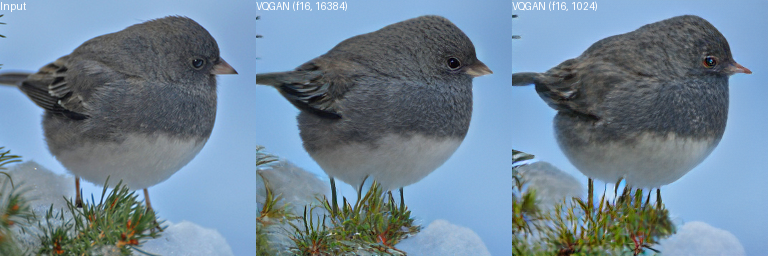

In [13]:
new_reconstruction_pipeline("/data/ty45972/taming-transformers/datasets/CUB_200_2011/images/131.Vesper_Sparrow/Vesper_Sparrow_0013_109937.jpg", size=256)

In [1]:
import torch
from omegaconf import OmegaConf
import os
from main import instantiate_from_config

def load_model(config_path, checkpoint_path, gpu=True, eval_mode=True):
    # 加载配置文件
    config = OmegaConf.load(config_path)
    
    # 实例化模型
    model = instantiate_from_config(config.model)
    
    # 加载模型权重
    if checkpoint_path and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location="cpu")
        if "global_step" in checkpoint:
            global_step = checkpoint["global_step"]
            print(f"Loaded model from global step {global_step}.")
        else:
            global_step = None
        
        if "state_dict" in checkpoint:
            model.load_state_dict(checkpoint["state_dict"])
        else:
            raise ValueError("Checkpoint does not contain state_dict.")
    else:
        raise ValueError(f"Checkpoint file {checkpoint_path} not found.")
    
    # 将模型移动到GPU（如果适用）
    if gpu:
        model = model.cuda()
    
    # 设置模型为评估模式（如果需要）
    if eval_mode:
        model.eval()
    
    return model

config_path = "/data/ty45972/taming-transformers/logs/2021-04-03T19-39-50_cin_transformer/configs/2021-04-03T19-39-50-project.yaml"
checkpoint_path = "/data/ty45972/taming-transformers/logs/2021-04-03T19-39-50_cin_transformer/checkpoints/last.ckpt"

model = load_model(config_path, checkpoint_path, gpu=True, eval_mode=True)


/home/myid/ty45972/miniconda3/envs/VQGAN/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Loaded model from global step 1095554.


In [4]:
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import numpy as np


rescale = lambda x: (x + 1.) / 2.

def chw_to_pillow(x):
    return Image.fromarray((255*rescale(x.detach().cpu().numpy().transpose(1,2,0))).clip(0,255).astype(np.uint8))


DEVICE = "cuda:0"
def img_encoder(x, model):
    z, _, [_, _, indices]= model.first_stage_model.encode(x)
    return z, indices

def preprocess(img, target_image_size=256, map_dalle=True):
    s = min(img.size)
    if s < target_image_size:
        raise ValueError(f'Min dimension for image {s} < {target_image_size}')
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return img

def process_image(image_path, size=256):
    image = Image.open(image_path)
    processed_img = preprocess(image, target_image_size=size, map_dalle=False).to(DEVICE)
    with torch.no_grad():
        z, indices = img_encoder(processed_img, model)
        # indices = torch.tensor([14164, 3927, 4635, 4648, 7491, 14793, 15575, 15525, 12016, 11605, 6920, 2524, 6123, 1495, 14703, 6889, 2524, 6113, 10228, 11665, 3037, 5314, 11307, 6092, 4236, 6092, 11725, 6889, 14164, 3927, 1258, 15771, 5062, 7436, 6889, 5772, 4465, 2474, 10508, 11605, 5305, 14793, 2524, 4945, 14176, 7436, 11725, 1755, 7436, 1972, 6876, 1268, 11665, 271, 1069, 11211, 12513, 7664, 1810, 632, 11665, 1755, 11725, 11665, 11427, 1069, 5666, 10508, 3212, 4967, 424, 1024, 3583, 15282, 13107, 1268, 15525, 8322, 8698, 11665, 9451, 7436, 14793, 7664, 598, 81, 5065, 7580, 15630, 14102, 11462, 13326, 7491, 11904, 7436, 11665, 13107, 7664, 11211, 8888, 2895, 15282, 13357, 8139, 14793, 16279, 11348, 14839, 15630, 3823, 1069, 13183, 3210, 8783, 1008, 1632, 13183, 7436, 2635, 11594, 15883, 7540, 11325, 11348, 8867, 1270, 6243, 12557, 6074, 7664, 13967, 1495, 11326, 1905, 15366, 7800, 8225, 13427, 6523, 6074, 6628, 2428, 12566, 3272, 12187, 14068, 11665, 12183, 14793, 14379, 1850, 641, 1270, 2779, 4950, 11497, 15945, 16017, 15729, 10278, 1208, 11993, 13687, 6994, 6328, 5319, 13757, 6123, 9713, 9753, 3442, 5401, 4238, 13500, 14681, 9570, 2214, 7465, 3927, 3001, 10741, 981, 1304, 15963, 825, 16146, 13326, 1069, 5098, 14547, 11708, 13401, 14531, 7540, 7798, 16338, 2237, 4904, 12786, 8170, 13370, 13687, 7781, 12165, 7466, 16338, 4395, 6808, 3061, 13401, 5068, 1008, 6242, 1736, 4644, 1905, 15645, 14965, 15647, 4473, 3974, 9890, 13175, 4198, 8609, 11665, 14176, 15213, 8609, 2237, 8380, 5031, 14420, 15645, 1208, 11820, 13845, 6948, 2705, 2705, 10620, 12861, 4395, 7103, 9131, 15282, 3768, 13967, 5900, 882, 3262, 1193, 9451, 2193, 10620, 7664]).to(DEVICE)
        # qzshape = [1, 256, 16, 16]
        print(indices)
        VQ_model = model.first_stage_model
        # x_sample = model.decode_to_img(indices, qzshape)
        x_sample = VQ_model.decode(z)
        image = chw_to_pillow(x_sample[0])
        image.save("bird.png")
    return x_sample


image_path = "/data/ty45972/taming-transformers/datasets/CUB_200_2011/images/131.Vesper_Sparrow/Vesper_Sparrow_0013_109937.jpg"
x_sample = process_image(image_path)

tensor([13586, 10553, 16017, 10813, 11348, 10813, 10813, 16279,    23, 12857,
          194, 13586, 14673, 11348, 11348, 11348,   699, 10553, 10813, 10813,
         6660,  2519, 13614,  4158, 10508, 15523, 13291,  1208,  1755,  1941,
         3272,  4301,  4903,  9589,  6660, 14420, 12143,  3042,  1304,  9900,
        11605,  4493, 14975,  9213,  6172, 12145,  7896,  4301, 14673, 15917,
         2439, 11716,  1597,  8075, 15525, 15826,  4815,  8698,  2383,  7979,
        15630, 14134,  9035,    23,  5053, 11716, 10295, 14008, 10997,  7696,
         9837,  7151,  3927,  8283,  5509,  4644,  9131,  8111, 13326, 12480,
        14076,  5900,  8928,  2920,  5314,  4945, 11456,  8834,  4815,  1586,
        10627,  4635, 13670,  7504,  4238,  8583,  1994,  8737,  5666,  4839,
         3442, 10297,  2922,  3583,  3037,  4945, 10813, 12623, 15213, 12016,
         7226,  9889, 10543,  1571, 14494,   663,  9377,  3168,  3742, 11605,
        12187, 14494,  2528, 12187, 11348,  6883, 10020, 11348, 